# Paper: Analysing Mathematical Reasoning Abilities of Neural Models
----
El dataset cuenta con una lista de problemas matemáticos clasificados de la siguiente manera:

    - algebra
    - numbers
    - polynomials
    - arithmetic
    - measurement
    - comparison
    - probability
    - calculus
    
Todos los problemas están constituidos por una pregunta textual como "¿qué es 30 + 535?" (Máximo 160 caracteres) y una respuesta textual "565" (máximo 30 caracteres). Por lo tanto, no es una representación abstracta de un problema matemático, sino muy humano y mezcla el procesamiento del lenguaje natural con conceptos matemáticos.

Para cada una de esas categorías, proporciona múltiples módulos de operación. Por ejemplo, en la categoría `algebra`:

    - mul
    - add_or_sub_in_base
    - simplificar_surd
    - mul_div_multiple
    - mezclado
    - raíz_integer_más cercana
    - div
    - add_or_sub
    - add_sub_multiple
    - add_sub_multiple_longer
    - mul_div_multiple_longer
    - div_big
    - mul_big
    - mixed_longer
    - add_or_sub_big

El problema se puede generar con diferentes dificultades:

    - train-easy
    - train-medium
    - train-hard

También proporciona conjuntos de datos de prueba para pruebas de "interpolación" que combinan todo tipo de problemas por categoría y pruebas de "extrapolación" para medir las capacidades de generalización de los modelos.

In [1]:
import math
import numpy as np
import torch
from torch.utils import data
import torch.optim as optim

import math_dataset
from math_dataset import MathDatasetManager

from transformer.Models import Transformer
from math_dataset import (
    random_split_dataset,
    question_answer_to_position_batch_collate_fn
)
import model_process
import utils
from tensorboard_utils import Tensorboard
from tensorboard_utils import tensorboard_event_accumulator

import checkpoints

import matplotlib
import numpy as np
import matplotlib.pyplot as plt
%matplotlib notebook

print("Torch Version", torch.__version__)

%load_ext autoreload
%autoreload 2


Torch Version 1.5.0+cpu


## Math Dataset Manager
Esta clase permite manejar los archivos del Math Dataset v1.0 y seleccionar diferentes partes de él, ya sea por categoría o módulo para generar un `Dataset` de `Pytorch` que se usará para el entrenamiento. 

In [2]:
mdsmgr = MathDatasetManager("C:\\Users\\jbardalesr\\Downloads\\mathematics_dataset-v1.0\\mathematics_dataset-v1.0")

initialized MultiFilesMathDataset with categories ['algebra', 'arithmetic', 'calculus', 'comparison', 'measurement', 'numbers', 'polynomials', 'probability'] and types ['train-easy', 'train-medium', 'train-hard', 'interpolate', 'extrapolate']


Verifica los tipos  de datos disponibles y los niveles de dificultades de los problemas `(difficulties + interpolate + extrapolate)`

In [3]:
print("types", list(mdsmgr.get_types()))

types ['train-easy', 'train-medium', 'train-hard', 'interpolate', 'extrapolate']


Verificando categorías disponibles

In [4]:
print("categories", list(mdsmgr.get_categories()))

categories ['algebra', 'arithmetic', 'calculus', 'comparison', 'measurement', 'numbers', 'polynomials', 'probability']


Verifica los módulos por cada categoria, en este ejemplo de `arithmetic`

In [5]:
print("modules of arithmetic", mdsmgr.get_modules_for_category('algebra'))

modules of arithmetic dict_keys(['linear_1d', 'linear_1d_composed', 'linear_2d', 'linear_2d_composed', 'polynomial_roots', 'polynomial_roots_composed', 'sequence_next_term', 'sequence_nth_term', 'polynomial_roots_big'])


## Inicialización

In [6]:
seed = 1
torch.manual_seed(seed)
device = torch.device("cpu")
print("device", device)

device cpu


## Entrenado con la categoría `algebra` modulo `linear_1d` modo `train-easy` 

In [7]:
exp_name = "math_ds_algebra_linear_1d_easy"
unique_id = "2021-07-25_0900"

### Dataset para el entrenamiento

In [8]:
ds = mdsmgr.build_dataset_from_module(
    'algebra', 'linear_1d', 'train-easy'
)
print("train-easy dataset size", len(ds))

train-easy dataset size 6666


C:\Users\jbardalesr\AppData\Roaming\Python\Python38\site-packages\pandas\core\frame.py:5034: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return super().rename(


### Dataset de interpolación

In [9]:
ds_interpolate = mdsmgr.build_dataset_from_module(
    'algebra', 'linear_1d', 'interpolate'
)
print("interpolate dataset size", len(ds_interpolate))

interpolate dataset size 100


### Creación del modelo Transformer


In [10]:
model = utils.build_transformer()


### Incializando un Optimizador básico


In [11]:
optimizer = optim.Adam(model.parameters(), lr=6e-6, betas=(0.9, 0.995), eps=1e-9)

### Creando Pytorch dataloaders

In [12]:
# Dividimos los datos en 90%/10% para los datos de entrenamiento y test y usamos los datos de interpolación para evaluar el test
train_ds, val_ds = math_dataset.random_split_dataset(ds, split_rate=0.9)

train_loader = data.DataLoader(
    train_ds, batch_size=128, shuffle=True, num_workers=4,
    collate_fn=question_answer_to_position_batch_collate_fn)

val_loader = data.DataLoader(
    val_ds, batch_size=128, shuffle=False, num_workers=4,
    collate_fn=question_answer_to_position_batch_collate_fn)

interpolate_loader = data.DataLoader(
    ds_interpolate, batch_size=128, shuffle=False, num_workers=4,
    collate_fn=question_answer_to_position_batch_collate_fn)


In [14]:
model: Transformer = model.to(device)


## Entrenando el modelo nivel Easy

In [15]:
model_process.train(
    name=exp_name +"_" + unique_id,
    model=model, 
    training_data=train_loader, validation_data=val_loader, interpolate_data=interpolate_loader,
    optimizer=optimizer, device=device,
    epochs=9, tb=tb, log_interval=100,
)

## Cargando los pesos de un modelo ya entrenado

In [17]:
_ = checkpoints.restore_checkpoint("./checkpoints/checkpoint_b37504_e7.pth","", model=model)

Attempting to extract state from ./checkpoints/checkpoint_b37504_e7.pth...
Loading model state_dict from state found in ./checkpoints/checkpoint_b37504_e7.pth


## Probando el modelo
Le diremos que resuelva la ecuación lineal $4w - 2w = 4$ cuya repuesta es $w=2$ 

In [18]:
model_process.predict_single("Solve 4*w - 2*w = 4 for w.", model, device, n_best=1)


..\aten\src\ATen\native\BinaryOps.cpp:81: UserWarning: Integer division of tensors using div or / is deprecated, and in a future release div will perform true division as in Python 3. Use true_divide or floor_divide (// in Python) instead.


[{'resp': '2', 'score': 0.0}]

## Grafica del Accuracy de Álgebra Linead 1-D
La perdida y la exactitud están los archivos 

In [21]:
import  matplotlib.pyplot as plt

accuracy_training = [0.65000, 0.67600, 0.70093, 0.72166, 0.73875, 0.78318, 0.78318]
accuracy_interpolation = [0.47162, 0.47007, 0.46725, 0.47441, 0.46276, 0.47253, 0.47253]
epoch = [0, 1, 2, 3, 4, 8, 9]

plt.title("Algebra Linear_1d Acurracy")
plt.plot(epoch, accuracy_training, label="Training", linestyle='-', marker='x')
plt.plot(epoch, accuracy_interpolation, label="Interpolation", linestyle='-', marker='x')
plt.xlabel("epoca")
plt.xticks(epoch)
plt.ylabel("accuracy")
plt.legend()
plt.show()

<IPython.core.display.Javascript object>

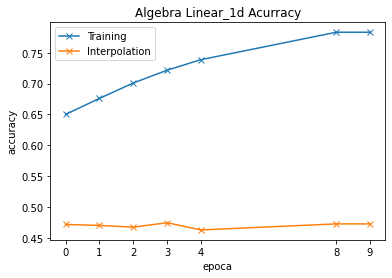

## Gráfica de la pérdida de Álgebra Linead 1-D

In [ ]:
import  matplotlib.pyplot as plt

loss_training = [1.0515344203820651, 0.9287042330397685, 0.8329559214935575, 0.7666831075142432,  0.7154526222560421]
loss_interpolation = [3.252589337567967, 3.5610522704500682, 3.6481729498539393, 3.847236221501331, 3.9576691305870875]
epoch = [0, 1, 2, 3, 4]

plt.title("Algebra Linear_1d Loss")
plt.plot(epoch, loss_training, label="Training", linestyle='-', marker='x')
plt.plot(epoch, loss_interpolation, label="Interpolation", linestyle='-', marker='x')
plt.xlabel("epoca")
plt.xticks(range(0, 5))
plt.ylabel("loss")
plt.legend()
plt.show()

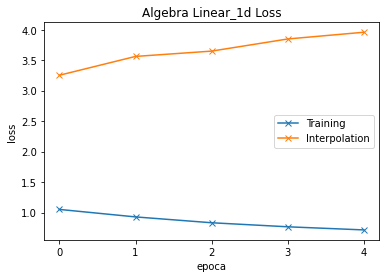

Nota: por problemas con la versión de MatplotLib no se pudo poner la imagen generada por esta librería, sino una imagen obtenida del GoogleColab con el mismo conjunto de entrenamiento